
Ridge


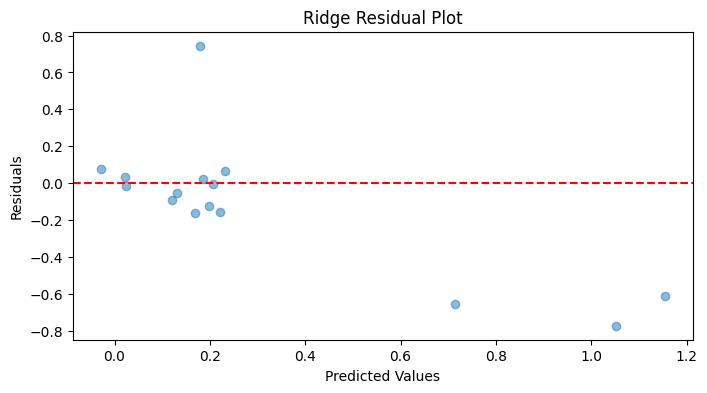

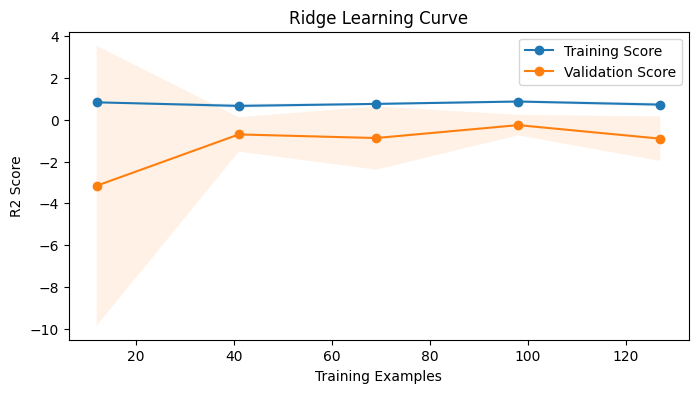


Lasso


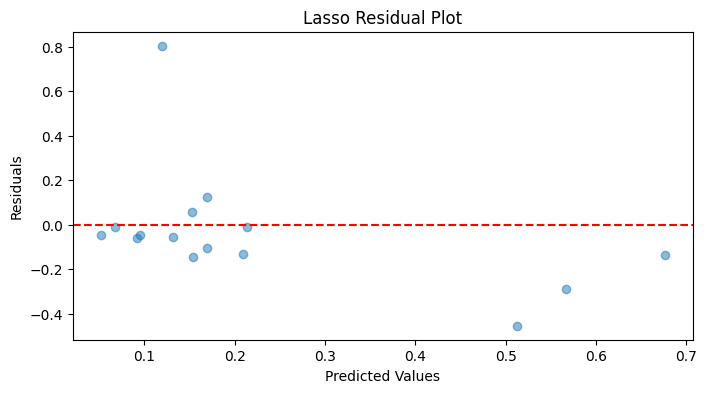

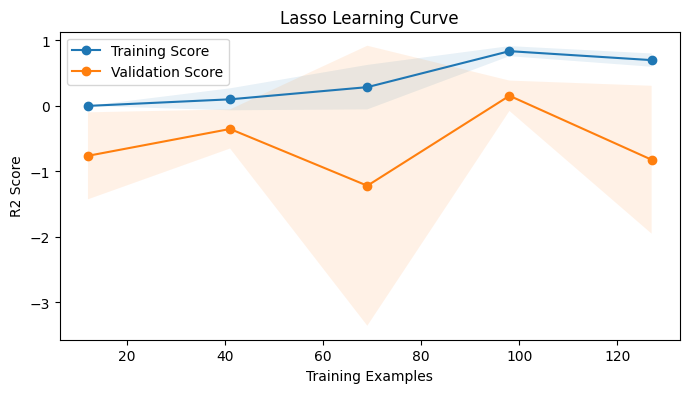


Decision Tree


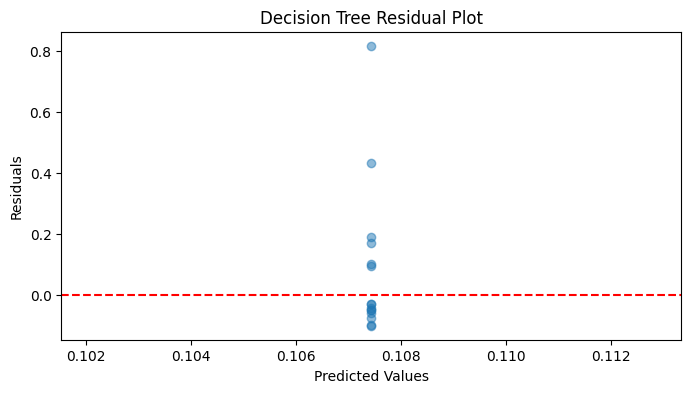

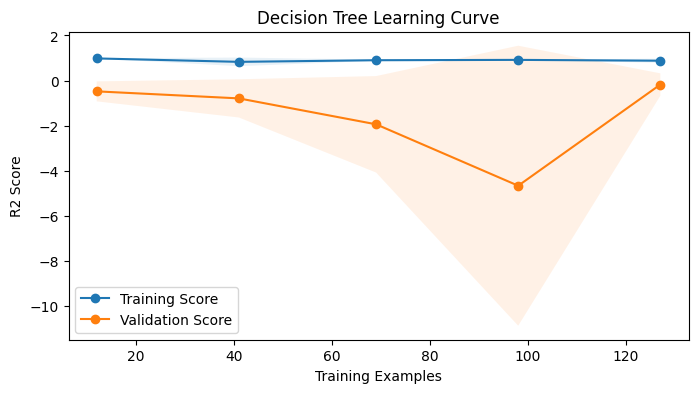


Random Forest


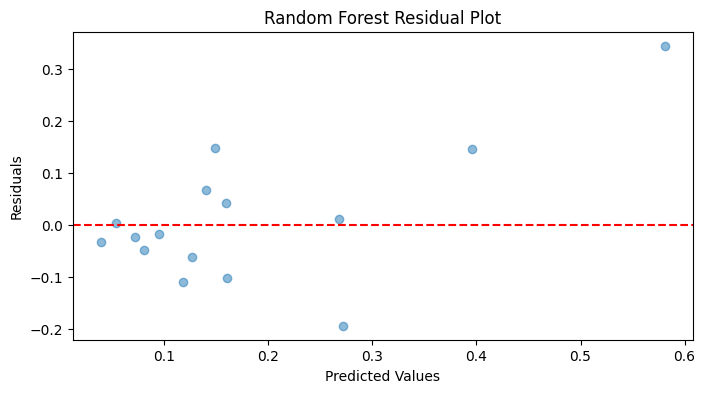

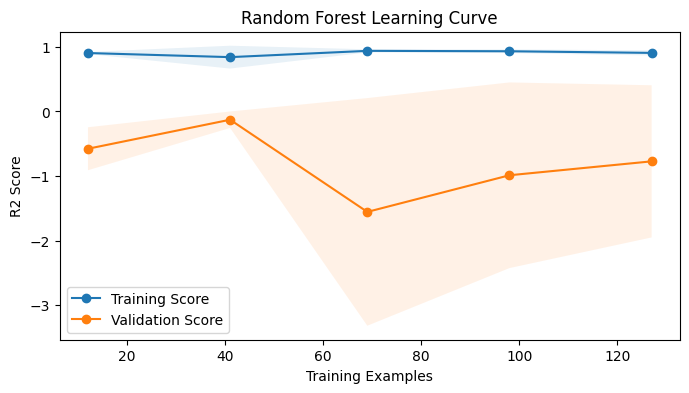


SVR


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


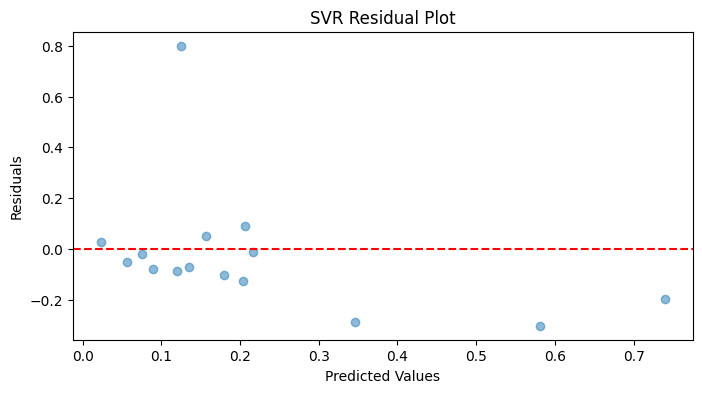

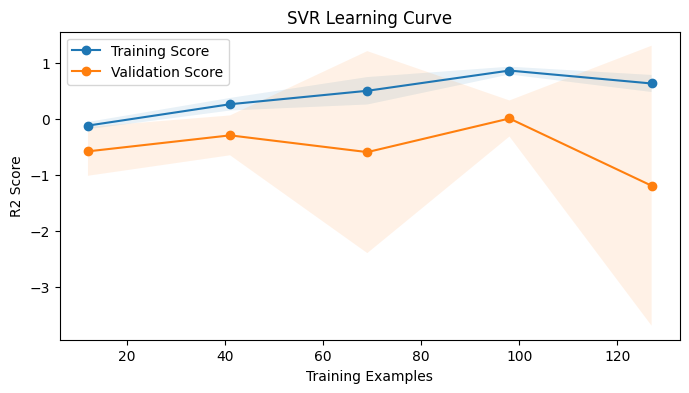


CatBoost


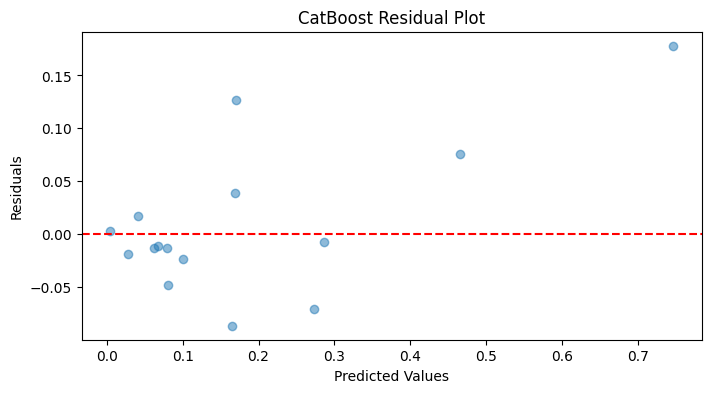

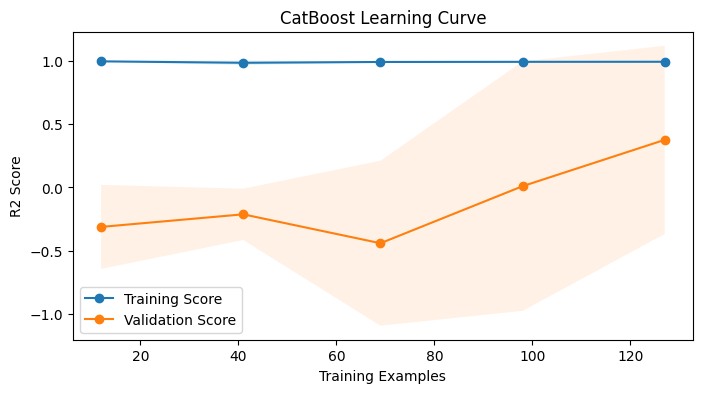



Final Results:
        Model         MAE        RMSE          R2    Train R2
        Ridge 0.21 ± 0.11 0.39 ± 0.23 0.03 ± 0.78 0.68 ± 0.02
        Lasso 0.20 ± 0.12 0.37 ± 0.25 0.27 ± 0.47 0.66 ± 0.02
Decision Tree 0.16 ± 0.07 0.26 ± 0.13 0.56 ± 0.36 0.91 ± 0.04
Random Forest 0.14 ± 0.10 0.24 ± 0.22 0.79 ± 0.09 0.90 ± 0.02
          SVR 0.19 ± 0.12 0.38 ± 0.31 0.42 ± 0.32 0.57 ± 0.04
     CatBoost 0.07 ± 0.06 0.13 ± 0.12 0.93 ± 0.07 0.99 ± 0.00


In [3]:
# Install required packages if missing
# !pip install catboost category_encoders scikit-learn pandas numpy matplotlib openpyxl

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from category_encoders import TargetEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# --------------------------
# DATA IMPORT AND CLEANING (FIXED)
# --------------------------
# Load and prepare data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)','Raw Material', 'Raw Material Cost (€/kg)'
])


# Proper NaN handling (CRITICAL FIX)
num_cols = [
    'Annual target quantity',
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)'
]
cat_cols = [
    'Production',  
    'Raw Material Designation', 'Surface Treatment'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# Define features and target
TARGET = 'Total cost with amortization (€/part)'
X = df.drop(TARGET, axis=1)
y = df[TARGET]

# --------------------------
# PREPROCESSING PIPELINES (FIXED SCALING)
# --------------------------
# For non-CatBoost models (scales encoded categorical features)
general_preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('encoder', TargetEncoder()), 
        ('scaler', RobustScaler())  # Added categorical feature scaling
    ]), cat_cols),
    ('num', RobustScaler(), num_cols)
])

# For CatBoost (no encoding needed)
catboost_preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)],
    remainder='passthrough'  # Preserve raw categorical features
)

# --------------------------
# MODEL CONFIGURATIONS 
# --------------------------
models = {
    'Ridge': (Ridge(), {'model__alpha': [0.1, 0.5, 1, 2]}),
    'Lasso': (Lasso(), {'model__alpha': [0.1, 0.5, 1]}),
    'Decision Tree': (DecisionTreeRegressor(), {
        'model__max_depth': [3, 4, None],
        'model__min_samples_split': [5, 10],
        'model__min_samples_leaf': [2, 4]
    }),
    'Random Forest': (RandomForestRegressor(), {
        'model__n_estimators': [30, 50],
        'model__max_depth': [3, 5],
        'model__min_samples_leaf': [2, 4]
    }),
    'SVR': (SVR(kernel='linear'), {
        'model__C': [3, 5.22, 7, 10],          # Focus around best value
        'model__epsilon': [0.08, 0.086, 0.09]
    
    }),
    'CatBoost': (CatBoostRegressor(verbose=0, 
        cat_features=list(range(len(num_cols), len(num_cols)+len(cat_cols)))),
        {'model__iterations': [50, 100],
         'model__depth': [3, 4],
         'model__learning_rate': [0.01, 0.1],
         'model__l2_leaf_reg': [1, 3]})
}

# --------------------------
# EVALUATION FRAMEWORK (WITH OVERFITTING CHECKS)
# --------------------------
results = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, (model, params) in models.items():
    print(f"\n{'='*30}\n{name}\n{'='*30}")
    
    # Create appropriate pipeline
    if name == 'CatBoost':
        pipeline = Pipeline([
            ('preprocessor', catboost_preprocessor),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('preprocessor', general_preprocessor),
            ('model', model)
        ])
    
    # Hyperparameter search with model-specific iterations
    n_iter = 20 if name == 'SVR' else 3  # More thorough SVR tuning
    search = RandomizedSearchCV(pipeline, params, cv=5, n_iter=n_iter,
                               scoring='neg_mean_absolute_error', n_jobs=-1)
    search.fit(X, y)
    
    # Cross-validation metrics
    mae_scores, rmse_scores, r2_scores = [], [], []
    train_r2_scores = []  # Track training performance
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        search.best_estimator_.fit(X_train, y_train)
        y_pred = search.best_estimator_.predict(X_test)
        
        # Training metrics (overfitting check)
        train_pred = search.best_estimator_.predict(X_train)
        train_r2 = r2_score(y_train, train_pred)
        train_r2_scores.append(train_r2)
        
        # Test metrics
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_scores.append(r2_score(y_test, y_pred))
    
    # Store results with training metrics
    results.append({
        'Model': name,
        'MAE': f"{np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}",
        'RMSE': f"{np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}",
        'R2': f"{np.mean(r2_scores):.2f} ± {np.std(r2_scores):.2f}",
        'Train R2': f"{np.mean(train_r2_scores):.2f} ± {np.std(train_r2_scores):.2f}"
    })
    
    # Residual plot
    plt.figure(figsize=(8,4))
    plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{name} Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()
    
    # Learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        search.best_estimator_, X, y, cv=5, 
        scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )
    
    plt.figure(figsize=(8,4))
    plt.plot(train_sizes, np.mean(train_scores, 1), 'o-', label='Training Score')
    plt.plot(train_sizes, np.mean(test_scores, 1), 'o-', label='Validation Score')
    plt.fill_between(train_sizes, 
                     np.mean(train_scores, 1) - np.std(train_scores, 1),
                     np.mean(train_scores, 1) + np.std(train_scores, 1), 
                     alpha=0.1)
    plt.fill_between(train_sizes, 
                     np.mean(test_scores, 1) - np.std(test_scores, 1),
                     np.mean(test_scores, 1) + np.std(test_scores, 1), 
                     alpha=0.1)
    plt.title(f'{name} Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.show()



# --------------------------
# RESULTS DISPLAY (WITH TRAINING METRICS)
# --------------------------
results_df = pd.DataFrame(results)
print("\n\nFinal Results:")
print(results_df.to_string(index=False))



Ridge


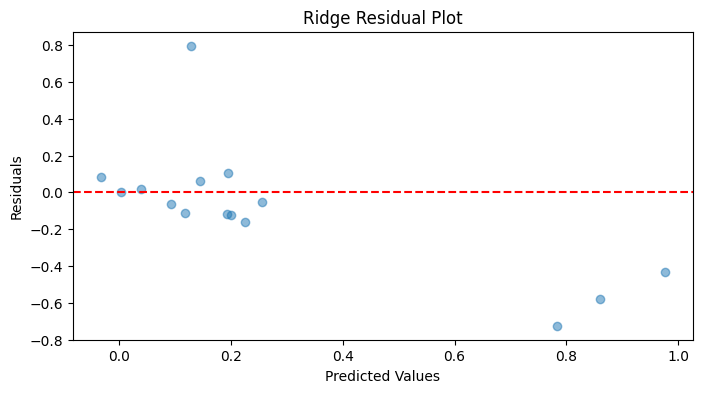

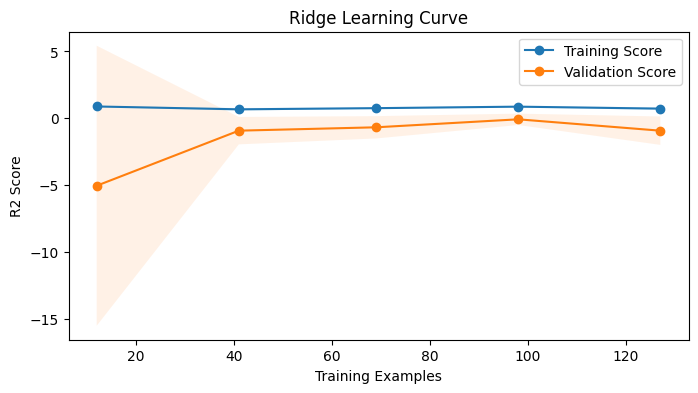


Lasso


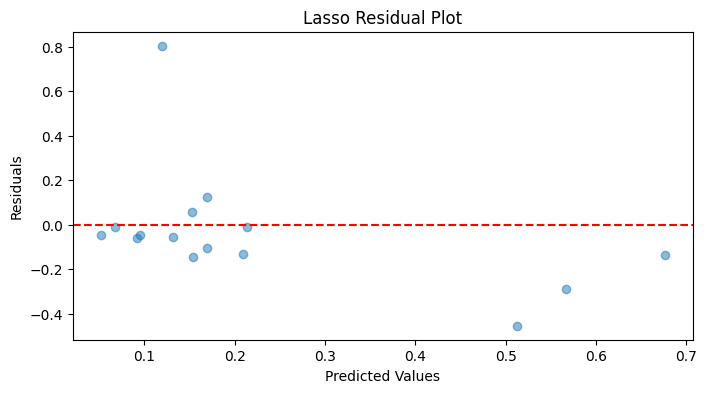

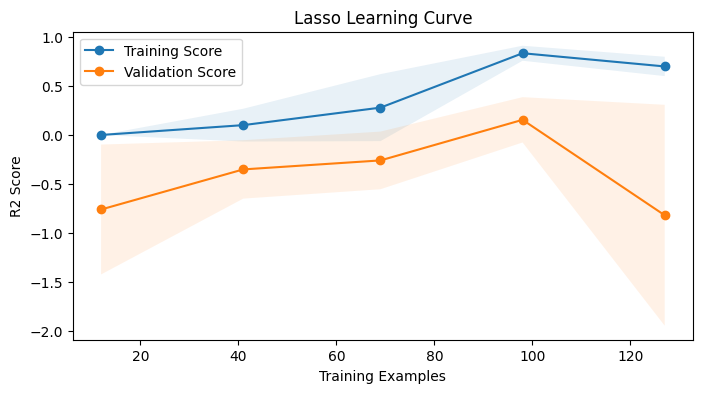


Decision Tree


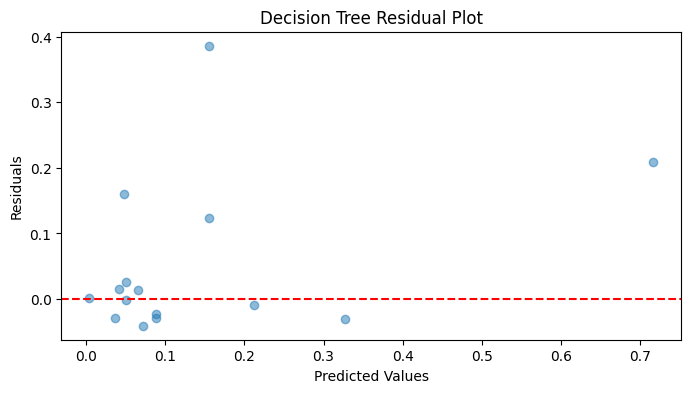

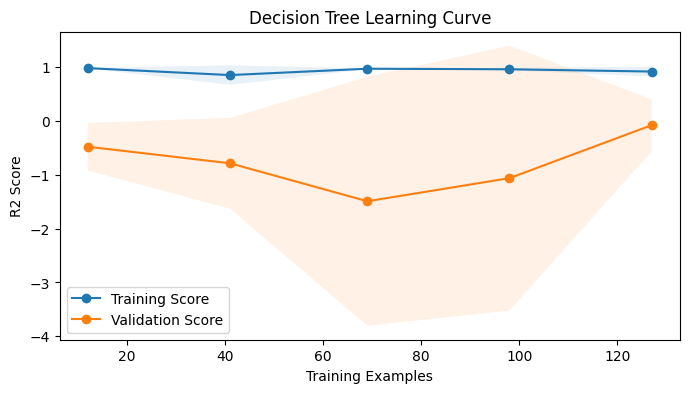


Random Forest


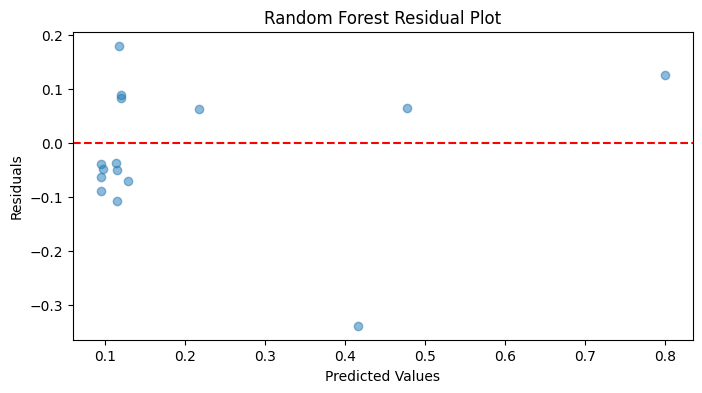

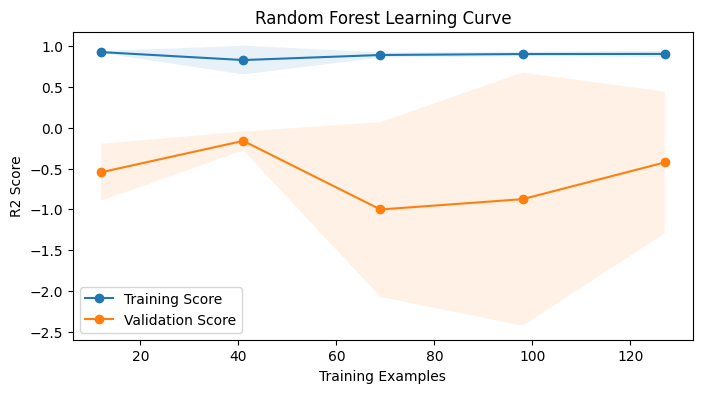


SVR


C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


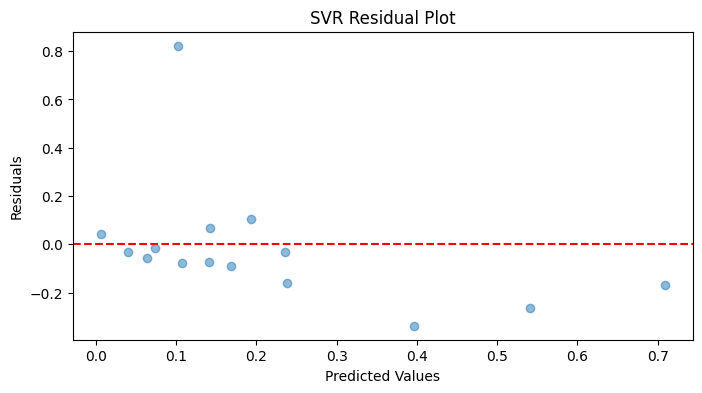

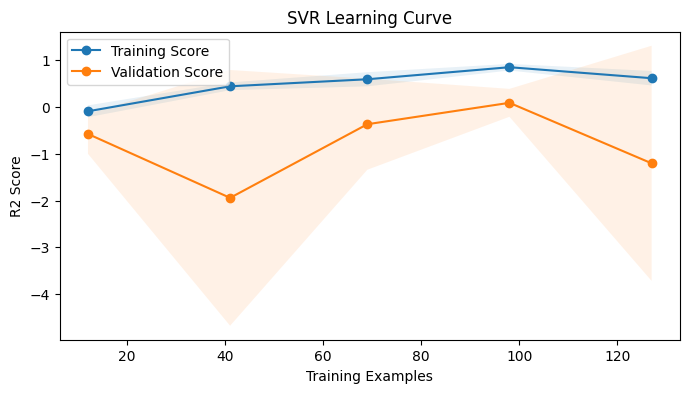


CatBoost


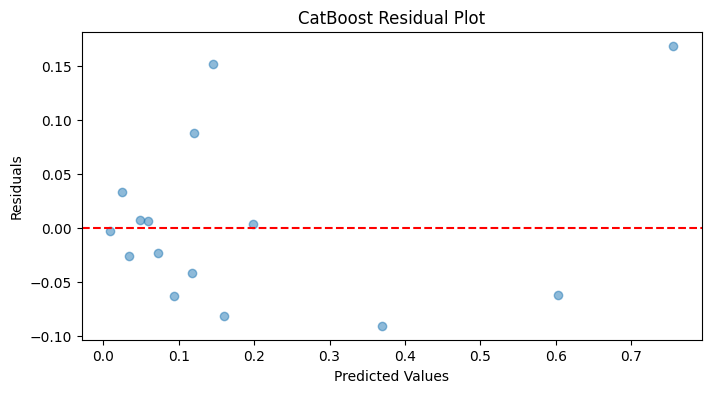

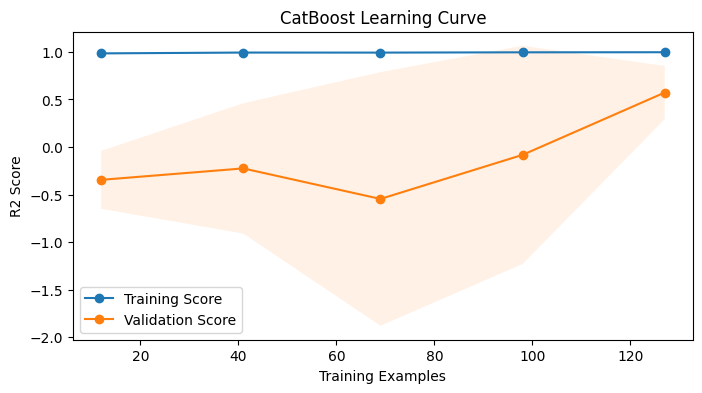



Final Results:
        Model         MAE        RMSE          R2    Train R2
        Ridge 0.21 ± 0.11 0.38 ± 0.23 0.04 ± 0.76 0.67 ± 0.02
        Lasso 0.20 ± 0.12 0.37 ± 0.25 0.27 ± 0.47 0.66 ± 0.02
Decision Tree 0.12 ± 0.06 0.22 ± 0.13 0.78 ± 0.10 0.94 ± 0.04
Random Forest 0.15 ± 0.09 0.25 ± 0.20 0.74 ± 0.14 0.89 ± 0.02
          SVR 0.18 ± 0.12 0.37 ± 0.32 0.47 ± 0.31 0.56 ± 0.04
     CatBoost 0.07 ± 0.05 0.13 ± 0.11 0.93 ± 0.06 1.00 ± 0.00


In [4]:
# Install required packages if missing
# !pip install catboost category_encoders scikit-learn pandas numpy matplotlib openpyxl

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from category_encoders import TargetEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# --------------------------
# DATA IMPORT AND CLEANING (FIXED)
# --------------------------
# Load and prepare data
df = pd.read_excel('Raw_Data_v0.xlsx', engine='openpyxl')
df = df.drop(columns=[
    'Ref#', 'Heat treatment', 'Other RM/Rivet/part cost (€/Part)',
    'Gross Weight (g)', 'Other assembled RM/Rivet/part',
    'Heat Treatment cost (€/Part)','Raw Material', 'Raw Material Cost (€/kg)', 'Surface Treatment'
])


# Proper NaN handling (CRITICAL FIX)
num_cols = [
    'Annual target quantity',
    'Thickness (mm)', 'Part Net Weight (g)', 
    'Surface Treatment cost (€/Part)'
]
cat_cols = [
    'Production',  
    'Raw Material Designation'
]

df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('Missing')

# Define features and target
TARGET = 'Total cost with amortization (€/part)'
X = df.drop(TARGET, axis=1)
y = df[TARGET]

# --------------------------
# PREPROCESSING PIPELINES (FIXED SCALING)
# --------------------------
# For non-CatBoost models (scales encoded categorical features)
general_preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('encoder', TargetEncoder()), 
        ('scaler', RobustScaler())  # Added categorical feature scaling
    ]), cat_cols),
    ('num', RobustScaler(), num_cols)
])

# For CatBoost (no encoding needed)
catboost_preprocessor = ColumnTransformer([
    ('num', RobustScaler(), num_cols)],
    remainder='passthrough'  # Preserve raw categorical features
)

# --------------------------
# MODEL CONFIGURATIONS 
# --------------------------
models = {
    'Ridge': (Ridge(), {'model__alpha': [0.1, 0.5, 1, 2]}),
    'Lasso': (Lasso(), {'model__alpha': [0.1, 0.5, 1]}),
    'Decision Tree': (DecisionTreeRegressor(), {
        'model__max_depth': [3, 4, None],
        'model__min_samples_split': [5, 10],
        'model__min_samples_leaf': [2, 4]
    }),
    'Random Forest': (RandomForestRegressor(), {
        'model__n_estimators': [30, 50],
        'model__max_depth': [3, 5],
        'model__min_samples_leaf': [2, 4]
    }),
    'SVR': (SVR(kernel='linear'), {
        'model__C': [3, 5.22, 7, 10],          # Focus around best value
        'model__epsilon': [0.08, 0.086, 0.09]
    
    }),
    'CatBoost': (CatBoostRegressor(verbose=0, 
        cat_features=list(range(len(num_cols), len(num_cols)+len(cat_cols)))),
        {'model__iterations': [50, 100],
         'model__depth': [3, 4],
         'model__learning_rate': [0.01, 0.1],
         'model__l2_leaf_reg': [1, 3]})
}

# --------------------------
# EVALUATION FRAMEWORK (WITH OVERFITTING CHECKS)
# --------------------------
results = []
kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, (model, params) in models.items():
    print(f"\n{'='*30}\n{name}\n{'='*30}")
    
    # Create appropriate pipeline
    if name == 'CatBoost':
        pipeline = Pipeline([
            ('preprocessor', catboost_preprocessor),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('preprocessor', general_preprocessor),
            ('model', model)
        ])
    
    # Hyperparameter search with model-specific iterations
    n_iter = 20 if name == 'SVR' else 3  # More thorough SVR tuning
    search = RandomizedSearchCV(pipeline, params, cv=5, n_iter=n_iter,
                               scoring='neg_mean_absolute_error', n_jobs=-1)
    search.fit(X, y)
    
    # Cross-validation metrics
    mae_scores, rmse_scores, r2_scores = [], [], []
    train_r2_scores = []  # Track training performance
    
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        search.best_estimator_.fit(X_train, y_train)
        y_pred = search.best_estimator_.predict(X_test)
        
        # Training metrics (overfitting check)
        train_pred = search.best_estimator_.predict(X_train)
        train_r2 = r2_score(y_train, train_pred)
        train_r2_scores.append(train_r2)
        
        # Test metrics
        mae_scores.append(mean_absolute_error(y_test, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2_scores.append(r2_score(y_test, y_pred))
    
    # Store results with training metrics
    results.append({
        'Model': name,
        'MAE': f"{np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}",
        'RMSE': f"{np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}",
        'R2': f"{np.mean(r2_scores):.2f} ± {np.std(r2_scores):.2f}",
        'Train R2': f"{np.mean(train_r2_scores):.2f} ± {np.std(train_r2_scores):.2f}"
    })
    
    # Residual plot
    plt.figure(figsize=(8,4))
    plt.scatter(y_pred, y_test - y_pred, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{name} Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()
    
    # Learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        search.best_estimator_, X, y, cv=5, 
        scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )
    
    plt.figure(figsize=(8,4))
    plt.plot(train_sizes, np.mean(train_scores, 1), 'o-', label='Training Score')
    plt.plot(train_sizes, np.mean(test_scores, 1), 'o-', label='Validation Score')
    plt.fill_between(train_sizes, 
                     np.mean(train_scores, 1) - np.std(train_scores, 1),
                     np.mean(train_scores, 1) + np.std(train_scores, 1), 
                     alpha=0.1)
    plt.fill_between(train_sizes, 
                     np.mean(test_scores, 1) - np.std(test_scores, 1),
                     np.mean(test_scores, 1) + np.std(test_scores, 1), 
                     alpha=0.1)
    plt.title(f'{name} Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('R2 Score')
    plt.legend()
    plt.show()



# --------------------------
# RESULTS DISPLAY (WITH TRAINING METRICS)
# --------------------------
results_df = pd.DataFrame(results)
print("\n\nFinal Results:")
print(results_df.to_string(index=False))
